In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


Dataset sizes:
Training samples: 3133
Validation samples: 349
Number of classes: 10


Starting model training...
Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3232 - loss: 2.2670
Epoch 1: val_accuracy improved from -inf to 0.16563, saving model to best_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 247s 5s/step - accuracy: 0.3249 - loss: 2.2626 - val_accuracy: 0.1656 - val_loss: 2.5197 - learning_rate: 1.0000e-04
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5079 - loss: 1.7335
Epoch 2: val_accuracy did not improve from 0.16563
48/48 ━━━━━━━━━━━━━━━━━━━━ 228s 5s/step - accuracy: 0.5083 - loss: 1.7324 - val_accuracy: 0.1614 - val_loss: 2.6116 - learning_rate: 1.0000e-04
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5642 - loss: 1.5548
Epoch 3: val_accuracy improved from 0.16563 to 0.18947, saving model to best_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 225s 5s/step - accuracy: 0.5642 - loss: 1.5547 - val_accuracy: 0.1895 - val_loss: 2.8125 - learn

<ipython-input-1-b8f76c9300c6>:252: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


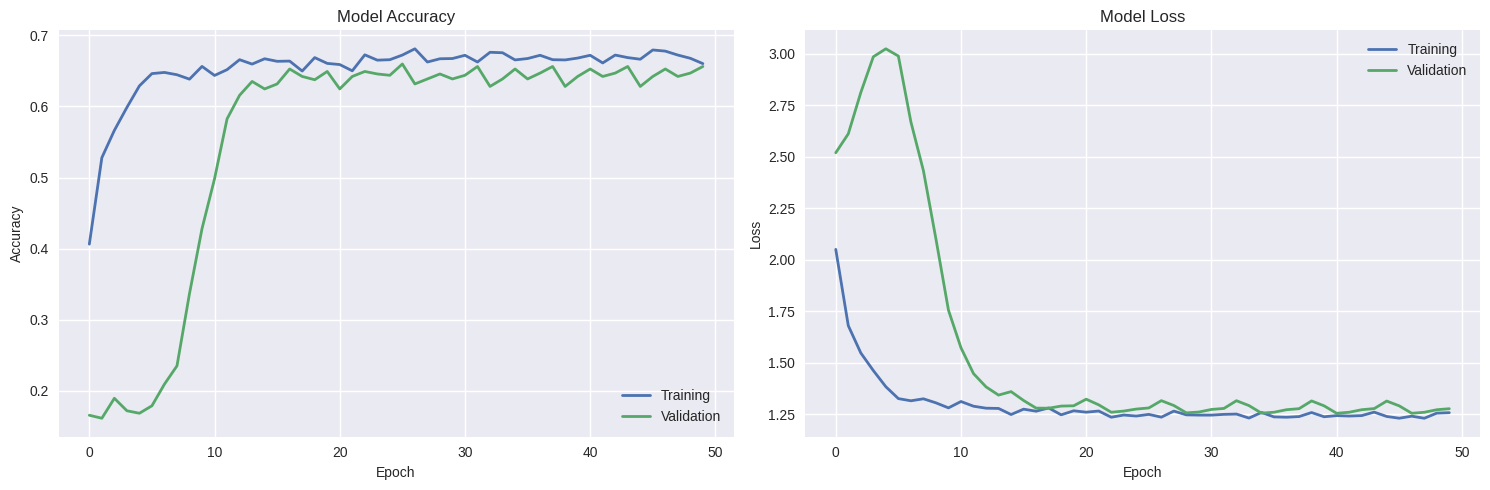

In [1]:
import os
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Modified configuration with 90-10 split
OPTIMIZED_CONFIG = {
    # /content/drive/MyDrive/Colab Notebooks/dataset/
    'data_path': '/kaggle/input/scanned-images-dataset-for-ocr-and-vlm-finetuning/dataset',
    'image_size': (128, 128),
    'batch_size': 64,
    'epochs': 50,
    'initial_learning_rate': 0.0001,
    'num_classes': 10,
    'train_split': 0.9,  # 90% for training
    'weight_decay': 0.0005,
    'dropout_rate': 0.3,
    'early_stopping_patience': 10,
}

def get_file_paths_and_labels(data_path):
    """Get all image paths and their corresponding labels"""
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_path))
    
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        if not os.path.isdir(class_path):
            continue
            
        for img_name in os.listdir(class_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_path, img_name))
                labels.append(class_idx)
    
    return np.array(image_paths), np.array(labels), class_names

def create_data_generators(config):
    """Create separate training and validation generators with fixed splits"""
    
    # Get all file paths and labels
    image_paths, labels, class_names = get_file_paths_and_labels(config['data_path'])
    
    if len(image_paths) == 0:
        raise ValueError("No images found in the data directory")
    
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        image_paths, 
        labels,
        train_size=config['train_split'],
        stratify=labels,
        random_state=42
    )
    
    # Create separate generators for training and validation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        # rotation_range=15,
        # width_shift_range=0.1,
        # height_shift_range=0.1,
        # zoom_range=0.1,
        # horizontal_flip=True,
        fill_mode='nearest'
    )
    
    val_datagen = ImageDataGenerator(
        rescale=1./255  # Only rescaling for validation
    )
    
    def generate_from_paths_and_labels(file_paths, labels, datagen, batch_size, is_training):
        num_samples = len(file_paths)
        num_classes = len(class_names)
        indices = np.arange(num_samples)
        
        while True:
            if is_training:
                np.random.shuffle(indices)
            
            for start in range(0, num_samples, batch_size):
                end = min(start + batch_size, num_samples)
                batch_indices = indices[start:end]
                
                # Initialize batch arrays
                batch_images = np.zeros((len(batch_indices),) + config['image_size'] + (3,))
                batch_labels = np.zeros((len(batch_indices), num_classes))
                
                # Load and preprocess images
                for idx, sample_idx in enumerate(batch_indices):
                    # Load image
                    img_path = file_paths[sample_idx]
                    img = tf.keras.preprocessing.image.load_img(
                        img_path,
                        target_size=config['image_size']
                    )
                    x = tf.keras.preprocessing.image.img_to_array(img)
                    
                    # Apply augmentation if training
                    if is_training:
                        x = train_datagen.random_transform(x)
                    
                    # Rescale
                    x = x / 255.0
                    
                    batch_images[idx] = x
                    batch_labels[idx] = tf.keras.utils.to_categorical(labels[sample_idx], num_classes)
                
                yield batch_images, batch_labels
    
    # Create generators
    train_generator = generate_from_paths_and_labels(
        X_train, y_train, train_datagen, config['batch_size'], is_training=True
    )
    
    validation_generator = generate_from_paths_and_labels(
        X_val, y_val, val_datagen, config['batch_size'], is_training=False
    )
    
    return train_generator, validation_generator, len(X_train), len(X_val), len(class_names)

def create_model(config):
    """Create CNN model with residual connections"""
    inputs = layers.Input(shape=(*config['image_size'], 3))
    
    # Initial convolution block
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(config['weight_decay']))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # First residual block
    shortcut = x
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(config['weight_decay']))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(config['weight_decay']))(x)
    x = layers.BatchNormalization()(x)
    shortcut = layers.Conv2D(64, (1, 1), padding='same')(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Second residual block
    shortcut = x
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(config['weight_decay']))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(config['weight_decay']))(x)
    x = layers.BatchNormalization()(x)
    shortcut = layers.Conv2D(128, (1, 1), padding='same')(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Global pooling and dense layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(config['weight_decay']))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(config['dropout_rate'])(x)
    outputs = layers.Dense(config['num_classes'], activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def main(config):
    """Main training function with improved stability"""
    # Set random seeds
    tf.random.set_seed(42)
    np.random.seed(42)
    
    try:
        # Create data generators with proper splits
        train_generator, validation_generator, train_samples, val_samples, num_classes = create_data_generators(config)
        
        print(f"\nDataset sizes:")
        print(f"Training samples: {train_samples}")
        print(f"Validation samples: {val_samples}")
        print(f"Number of classes: {num_classes}\n")
        
        # Calculate steps
        steps_per_epoch = train_samples // config['batch_size']
        validation_steps = val_samples // config['batch_size']
        
        # Ensure at least one step
        steps_per_epoch = max(1, steps_per_epoch)
        validation_steps = max(1, validation_steps)
        
        # Create and compile model
        model = create_model(config)
        
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=config['initial_learning_rate'],
            clipnorm=1.0
        )
        
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=config['early_stopping_patience'],
                restore_best_weights=True,
                verbose=1
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=3,
                min_lr=1e-7,
                verbose=1
            ),
            tf.keras.callbacks.ModelCheckpoint(
                filepath='best_model.keras',
                monitor='val_accuracy',
                save_best_only=True,
                mode='max',
                verbose=1
            )
        ]
        
        # Train the model
        print("\nStarting model training...")
        history = model.fit(
            train_generator,
            epochs=config['epochs'],
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_generator,
            validation_steps=validation_steps,
            callbacks=callbacks,
            verbose=1
        )
        
        return model, history
        
    except Exception as e:
        print(f"Error in main function: {str(e)}")
        raise

def plot_training_history(history):
    """Plot training metrics"""
    plt.style.use('seaborn')
    plt.figure(figsize=(15, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    plt.title('Model Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Accuracy', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
    plt.title('Model Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    try:
        # Verify data path exists
        if not os.path.exists(OPTIMIZED_CONFIG['data_path']):
            raise ValueError(f"Data path does not exist: {OPTIMIZED_CONFIG['data_path']}")
        
        model, history = main(OPTIMIZED_CONFIG)
        plot_training_history(history)
        
    except Exception as e:
        print(f"Program failed with error: {str(e)}")


Dataset sizes:
Training samples: 3133
Validation samples: 349
Number of classes: 10


Starting model training...
Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2743 - loss: 2.4065
Epoch 1: val_accuracy improved from -inf to 0.16563, saving model to best_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 224s 5s/step - accuracy: 0.2762 - loss: 2.4010 - val_accuracy: 0.1656 - val_loss: 2.5323 - learning_rate: 1.0000e-04
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4875 - loss: 1.7727
Epoch 2: val_accuracy did not improve from 0.16563
48/48 ━━━━━━━━━━━━━━━━━━━━ 210s 4s/step - accuracy: 0.4880 - loss: 1.7715 - val_accuracy: 0.1614 - val_loss: 2.6091 - learning_rate: 1.0000e-04
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5752 - loss: 1.5756
Epoch 3: val_accuracy improved from 0.16563 to 0.18947, saving model to best_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - accuracy: 0.5753 - loss: 1.5752 - val_accuracy: 0.1895 - val_loss: 2.7433 - learn

<ipython-input-2-b8f76c9300c6>:252: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


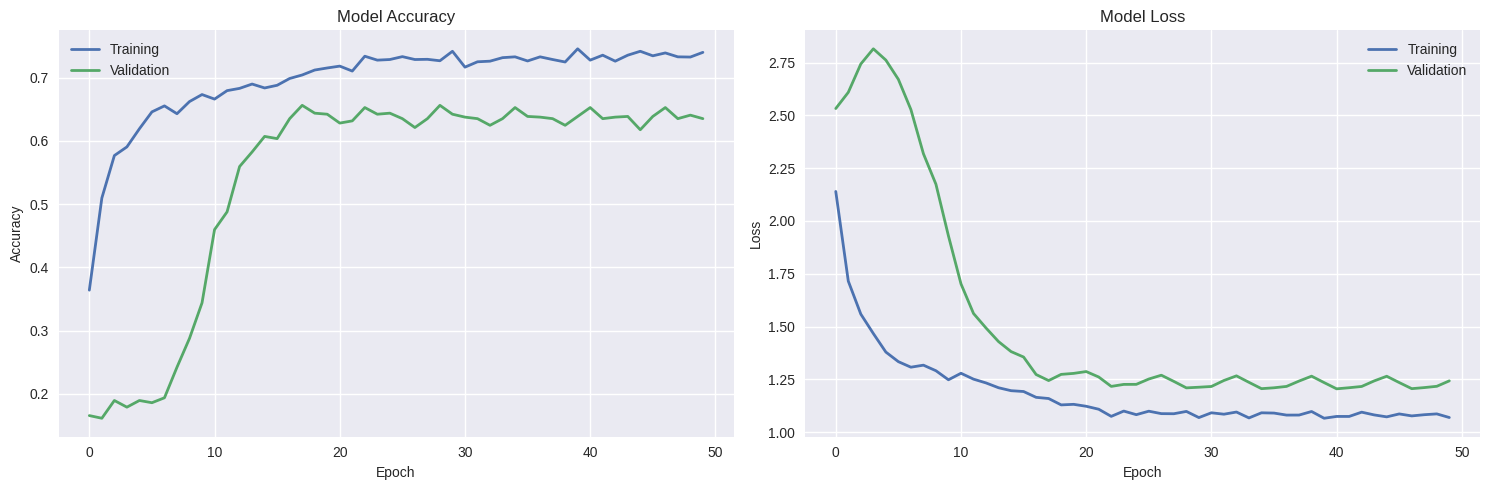

In [2]:
import os
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Modified configuration with 90-10 split
OPTIMIZED_CONFIG = {
    # /content/drive/MyDrive/Colab Notebooks/dataset/
    'data_path': '/kaggle/input/scanned-images-dataset-for-ocr-and-vlm-finetuning/dataset',
    'image_size': (128, 128),
    'batch_size': 64,
    'epochs': 50,
    'initial_learning_rate': 0.0001,
    'num_classes': 10,
    'train_split': 0.9,  # 90% for training
    'weight_decay': 0.0005,
    'dropout_rate': 0.3,
    'early_stopping_patience': 10,
}

def get_file_paths_and_labels(data_path):
    """Get all image paths and their corresponding labels"""
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_path))
    
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        if not os.path.isdir(class_path):
            continue
            
        for img_name in os.listdir(class_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_path, img_name))
                labels.append(class_idx)
    
    return np.array(image_paths), np.array(labels), class_names

def create_data_generators(config):
    """Create separate training and validation generators with fixed splits"""
    
    # Get all file paths and labels
    image_paths, labels, class_names = get_file_paths_and_labels(config['data_path'])
    
    if len(image_paths) == 0:
        raise ValueError("No images found in the data directory")
    
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        image_paths, 
        labels,
        train_size=config['train_split'],
        stratify=labels,
        random_state=42
    )
    
    # Create separate generators for training and validation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        # rotation_range=15,
        # width_shift_range=0.1,
        # height_shift_range=0.1,
        # zoom_range=0.1,
        # horizontal_flip=True,
        fill_mode='nearest'
    )
    
    val_datagen = ImageDataGenerator(
        rescale=1./255  # Only rescaling for validation
    )
    
    def generate_from_paths_and_labels(file_paths, labels, datagen, batch_size, is_training):
        num_samples = len(file_paths)
        num_classes = len(class_names)
        indices = np.arange(num_samples)
        
        while True:
            if is_training:
                np.random.shuffle(indices)
            
            for start in range(0, num_samples, batch_size):
                end = min(start + batch_size, num_samples)
                batch_indices = indices[start:end]
                
                # Initialize batch arrays
                batch_images = np.zeros((len(batch_indices),) + config['image_size'] + (3,))
                batch_labels = np.zeros((len(batch_indices), num_classes))
                
                # Load and preprocess images
                for idx, sample_idx in enumerate(batch_indices):
                    # Load image
                    img_path = file_paths[sample_idx]
                    img = tf.keras.preprocessing.image.load_img(
                        img_path,
                        target_size=config['image_size']
                    )
                    x = tf.keras.preprocessing.image.img_to_array(img)
                    
                    # Apply augmentation if training
                    if is_training:
                        x = train_datagen.random_transform(x)
                    
                    # Rescale
                    x = x / 255.0
                    
                    batch_images[idx] = x
                    batch_labels[idx] = tf.keras.utils.to_categorical(labels[sample_idx], num_classes)
                
                yield batch_images, batch_labels
    
    # Create generators
    train_generator = generate_from_paths_and_labels(
        X_train, y_train, train_datagen, config['batch_size'], is_training=True
    )
    
    validation_generator = generate_from_paths_and_labels(
        X_val, y_val, val_datagen, config['batch_size'], is_training=False
    )
    
    return train_generator, validation_generator, len(X_train), len(X_val), len(class_names)

def create_model(config):
    """Create CNN model with residual connections"""
    inputs = layers.Input(shape=(*config['image_size'], 3))
    
    # Initial convolution block
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(config['weight_decay']))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # First residual block
    shortcut = x
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(config['weight_decay']))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(config['weight_decay']))(x)
    x = layers.BatchNormalization()(x)
    shortcut = layers.Conv2D(64, (1, 1), padding='same')(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Second residual block
    shortcut = x
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(config['weight_decay']))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(config['weight_decay']))(x)
    x = layers.BatchNormalization()(x)
    shortcut = layers.Conv2D(128, (1, 1), padding='same')(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Global pooling and dense layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(config['weight_decay']))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(config['dropout_rate'])(x)
    outputs = layers.Dense(config['num_classes'], activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def main(config):
    """Main training function with improved stability"""
    # Set random seeds
    tf.random.set_seed(42)
    np.random.seed(42)
    
    try:
        # Create data generators with proper splits
        train_generator, validation_generator, train_samples, val_samples, num_classes = create_data_generators(config)
        
        print(f"\nDataset sizes:")
        print(f"Training samples: {train_samples}")
        print(f"Validation samples: {val_samples}")
        print(f"Number of classes: {num_classes}\n")
        
        # Calculate steps
        steps_per_epoch = train_samples // config['batch_size']
        validation_steps = val_samples // config['batch_size']
        
        # Ensure at least one step
        steps_per_epoch = max(1, steps_per_epoch)
        validation_steps = max(1, validation_steps)
        
        # Create and compile model
        model = create_model(config)
        
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=config['initial_learning_rate'],
            clipnorm=1.0
        )
        
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=config['early_stopping_patience'],
                restore_best_weights=True,
                verbose=1
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=3,
                min_lr=1e-7,
                verbose=1
            ),
            tf.keras.callbacks.ModelCheckpoint(
                filepath='best_model.keras',
                monitor='val_accuracy',
                save_best_only=True,
                mode='max',
                verbose=1
            )
        ]
        
        # Train the model
        print("\nStarting model training...")
        history = model.fit(
            train_generator,
            epochs=config['epochs'],
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_generator,
            validation_steps=validation_steps,
            callbacks=callbacks,
            verbose=1
        )
        
        return model, history
        
    except Exception as e:
        print(f"Error in main function: {str(e)}")
        raise

def plot_training_history(history):
    """Plot training metrics"""
    plt.style.use('seaborn')
    plt.figure(figsize=(15, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    plt.title('Model Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Accuracy', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
    plt.title('Model Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    try:
        # Verify data path exists
        if not os.path.exists(OPTIMIZED_CONFIG['data_path']):
            raise ValueError(f"Data path does not exist: {OPTIMIZED_CONFIG['data_path']}")
        
        model, history = main(OPTIMIZED_CONFIG)
        plot_training_history(history)
        
    except Exception as e:
        print(f"Program failed with error: {str(e)}")

In [ ]:
import os
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

OPTIMIZED_CONFIG = {
    'data_path': '/kaggle/input/scanned-images-dataset-for-ocr-and-vlm-finetuning/dataset',
    'image_size': (224, 224),  # Increased from 128x128
    'batch_size': 32,  # Reduced from 64 for better stability
    'epochs': 100,  # Increased for better convergence
    'initial_learning_rate': 0.001,  # Increased initial learning rate
    'num_classes': 10,
    'train_split': 0.8,  # Adjusted split ratio
    'validation_split': 0.1,
    'test_split': 0.1,
    'weight_decay': 0.001,
    'dropout_rate': 0.5,  # Increased dropout
    'early_stopping_patience': 15,  # Increased patience
    'mixup_alpha': 0.2,  # Added mixup augmentation
}

def mixup_data(x, y, alpha=0.2):
    """Performs mixup on the input data and label."""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = tf.shape(x)[0]
    indices = tf.random.shuffle(tf.range(batch_size))
    
    mixed_x = lam * x + (1 - lam) * tf.gather(x, indices)
    mixed_y = lam * y + (1 - lam) * tf.gather(y, indices)
    
    return mixed_x, mixed_y

def create_data_generators(config):
    """Enhanced data generator with better augmentation and preprocessing"""
    image_paths, labels, class_names = get_file_paths_and_labels(config['data_path'])
    
    # Split into train, validation, and test sets
    X_temp, X_test, y_temp, y_test = train_test_split(
        image_paths, labels, 
        test_size=config['test_split'],
        stratify=labels,
        random_state=42
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=config['validation_split']/(1-config['test_split']),
        stratify=y_temp,
        random_state=42
    )
    
    # Enhanced augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=[0.8, 1.2],
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input
    )
    
    # Only rescaling for validation/test
    valid_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input
    )
    return (
    generate_from_paths_and_labels(X_train, y_train, train_datagen, config['batch_size'], True),
    generate_from_paths_and_labels(X_val, y_val, valid_datagen, config['batch_size'], False),
    generate_from_paths_and_labels(X_test, y_test, valid_datagen, config['batch_size'], False),
    len(X_train), len(X_val), len(X_test), len(class_names)
    )
    
def generate_from_paths_and_labels(file_paths, labels, datagen, batch_size, is_training):
        while True:
            indices = np.arange(len(file_paths))
            if is_training:
                np.random.shuffle(indices)
            
            for start in range(0, len(file_paths), batch_size):
                batch_indices = indices[start:start + batch_size]
                batch_paths = file_paths[batch_indices]
                batch_labels = labels[batch_indices]
                
                # Load and preprocess images
                batch_images = np.zeros((len(batch_indices),) + config['image_size'] + (3,))
                batch_labels_categorical = tf.keras.utils.to_categorical(
                    batch_labels, num_classes=config['num_classes']
                )
                
                for idx, path in enumerate(batch_paths):
                    img = tf.keras.preprocessing.image.load_img(
                        path, target_size=config['image_size']
                    )
                    img = tf.keras.preprocessing.image.img_to_array(img)
                    img = datagen.random_transform(img) if is_training else img
                    batch_images[idx] = img
                
                if is_training and config['mixup_alpha'] > 0:
                    batch_images, batch_labels_categorical = mixup_data(
                        batch_images, 
                        batch_labels_categorical, 
                        config['mixup_alpha']
                    )
                
                yield batch_images, batch_labels_categorical
    


def create_model(config):
    """Create an improved model architecture using ResNet50 as base"""
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(*config['image_size'], 3)
    )
    
    # Freeze early layers
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(config['weight_decay'])),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(config['dropout_rate']),
        layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(config['weight_decay'])),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(config['dropout_rate']),
        layers.Dense(config['num_classes'], activation='softmax')
    ])
    
    return model

def create_callbacks(config):
    """Create enhanced training callbacks"""
    return [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=config['early_stopping_patience'],
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath='best_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir='./logs',
            histogram_freq=1,
            update_freq='epoch'
        )
    ]

def main(config):
    """Enhanced main training function"""
    tf.random.set_seed(42)
    np.random.seed(42)
    
    # Create data generators
    train_gen, val_gen, test_gen, train_samples, val_samples, test_samples, num_classes = create_data_generators(config)
    
    # Update number of classes if needed
    config['num_classes'] = num_classes
    
    # Create and compile model with learning rate schedule
    model = create_model(config)
    
    # Cosine decay learning rate schedule
    initial_learning_rate = config['initial_learning_rate']
    decay_steps = config['epochs'] * (train_samples // config['batch_size'])
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate, decay_steps
    )
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=lr_schedule,
        clipnorm=1.0
    )
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
    )
    
    # Train the model
    history = model.fit(
        train_gen,
        epochs=config['epochs'],
        steps_per_epoch=train_samples // config['batch_size'],
        validation_data=val_gen,
        validation_steps=val_samples // config['batch_size'],
        callbacks=create_callbacks(config),
        verbose=1
    )
    
    # Evaluate on test set
    test_results = model.evaluate(
        test_gen,
        steps=test_samples // config['batch_size'],
        verbose=1
    )
    
    return model, history, test_results